In [1]:
#| include: false 
import os

from sklearn.utils import shuffle, validation 
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"

# Importación de las librerías necesarias

In [2]:
import os 
from PIL import Image
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from glob import glob
# ------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# ------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ------------------------------
import warnings
warnings.filterwarnings('ignore')

2025-03-31 11:46:33.077904: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-31 11:46:33.183198: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-31 11:46:33.468875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743414393.680719   72717 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743414393.707886   72717 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743414393.979293   72717 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

# Preprocesamiento
## Cargar los datos

In [3]:
#| include: false
import kagglehub 
import os
import shutil

target_dir = "kaggle/input/brain-tumor-mri-dataset/"

if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')
    
    shutil.move(path, target_dir)

In [4]:
def train_df(tr_path):
    classes, class_path = zip(*[(label, os.path.join(tr_path, label, image))
                                for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_path, 'Class': classes})
    return tr_df

In [5]:
def test_df(tr_path):
    classes, class_path = zip(*[(label, os.path.join(tr_path, label, image))
                                for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                for image in os.listdir(os.path.join(tr_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_path, 'Class': classes})
    return ts_df

In [6]:
tr_df = train_df('kaggle/input/brain-tumor-mri-dataset/Training')

tr_df

,Class Path,Class
0,kaggle/input/brain-tumor-mri-dataset/Training/...,notumor
1,kaggle/input/brain-tumor-mri-dataset/Training/...,notumor
2,kaggle/input/brain-tumor-mri-dataset/Training/...,notumor
3,kaggle/input/brain-tumor-mri-dataset/Training/...,notumor
4,kaggle/input/brain-tumor-mri-dataset/Training/...,notumor
...,...,...
5707,kaggle/input/brain-tumor-mri-dataset/Training/...,glioma
5708,kaggle/input/brain-tumor-mri-dataset/Training/...,glioma
5709,kaggle/input/brain-tumor-mri-dataset/Training/...,glioma
5710,kaggle/input/brain-tumor-mri-dataset/Training/...,glioma


In [7]:
ts_df = test_df('kaggle/input/brain-tumor-mri-dataset/Testing')

ts_df

,Class Path,Class
0,kaggle/input/brain-tumor-mri-dataset/Testing/n...,notumor
1,kaggle/input/brain-tumor-mri-dataset/Testing/n...,notumor
2,kaggle/input/brain-tumor-mri-dataset/Testing/n...,notumor
3,kaggle/input/brain-tumor-mri-dataset/Testing/n...,notumor
4,kaggle/input/brain-tumor-mri-dataset/Testing/n...,notumor
...,...,...
1306,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma
1307,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma
1308,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma
1309,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma


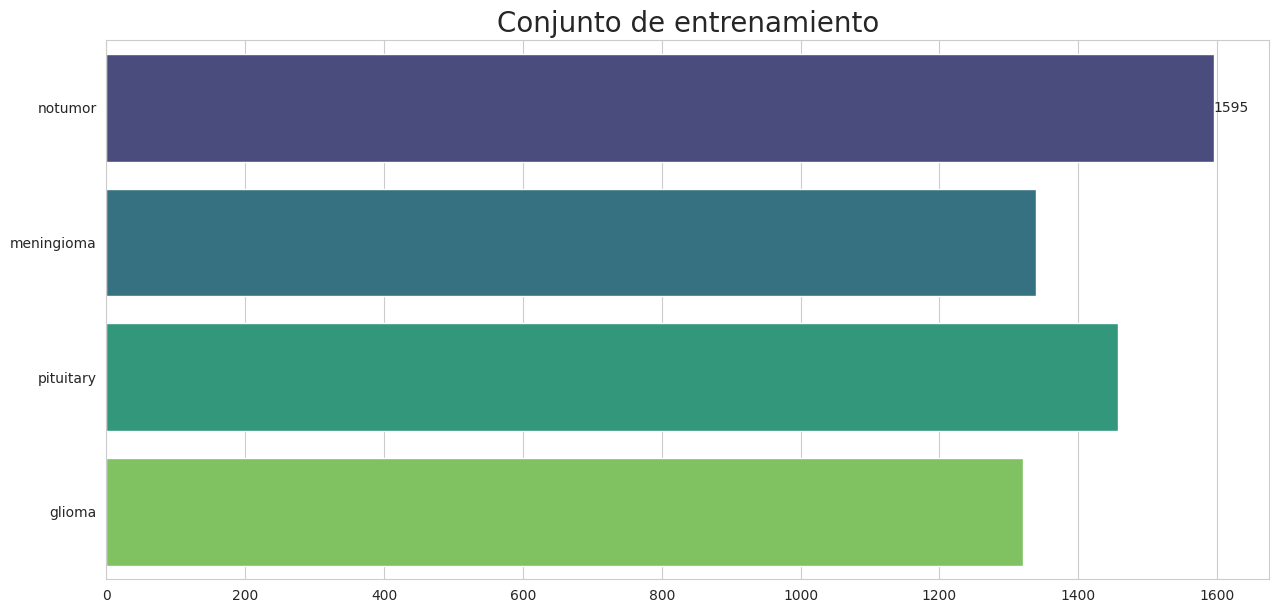

In [8]:
# Contamos las imágenes en cada clase de los datos de entrenamiento
plt.figure(figsize=(15, 7))

ax = sns.countplot(data=tr_df, y=tr_df['Class'], palette='viridis')
plt.xlabel('')
plt.ylabel('')
plt.title("Conjunto de entrenamiento", fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

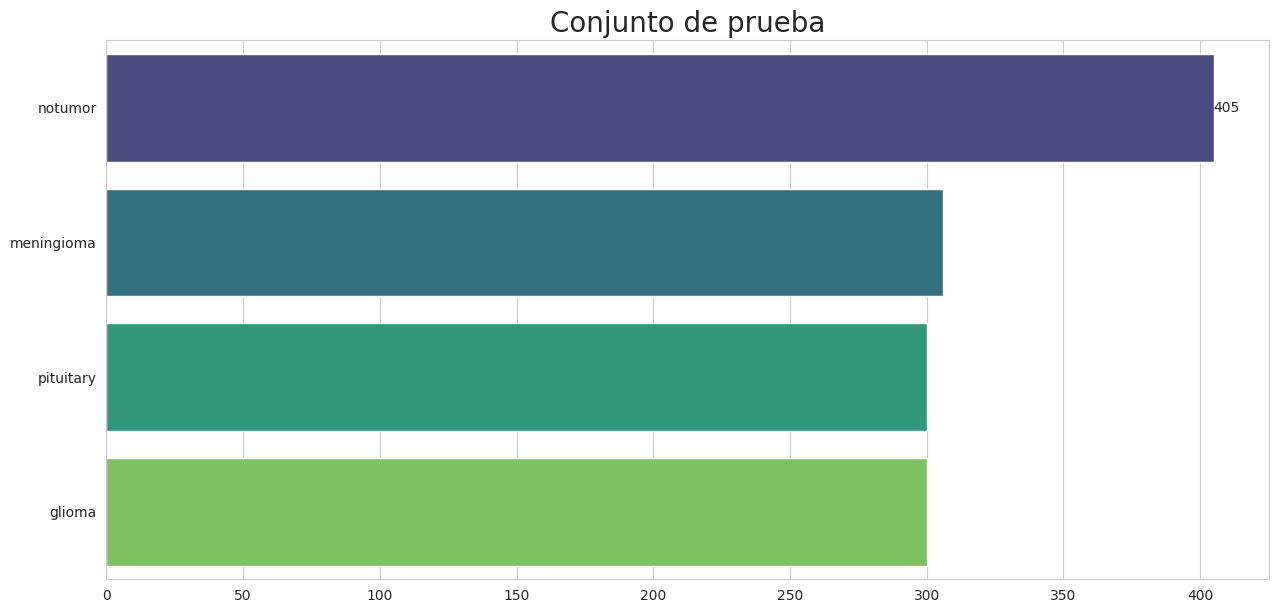

In [9]:
# Contamos las imágenes en cada clase de los datos de test
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='')
ax.bar_label(ax.containers[0])
plt.title('Conjunto de prueba', fontsize=20)
plt.show()

## División de los datos 

In [10]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

valid_df

,Class Path,Class
1297,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma
423,kaggle/input/brain-tumor-mri-dataset/Testing/m...,meningioma
772,kaggle/input/brain-tumor-mri-dataset/Testing/p...,pituitary
478,kaggle/input/brain-tumor-mri-dataset/Testing/m...,meningioma
1120,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma
...,...,...
1070,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma
254,kaggle/input/brain-tumor-mri-dataset/Testing/n...,notumor
1284,kaggle/input/brain-tumor-mri-dataset/Testing/g...,glioma
599,kaggle/input/brain-tumor-mri-dataset/Testing/m...,meningioma


## Preprocesamiento de los datos 

In [11]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=16,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                    y_col='Class', batch_size=16,
                                    target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Mostramos ejemplos de los datos 

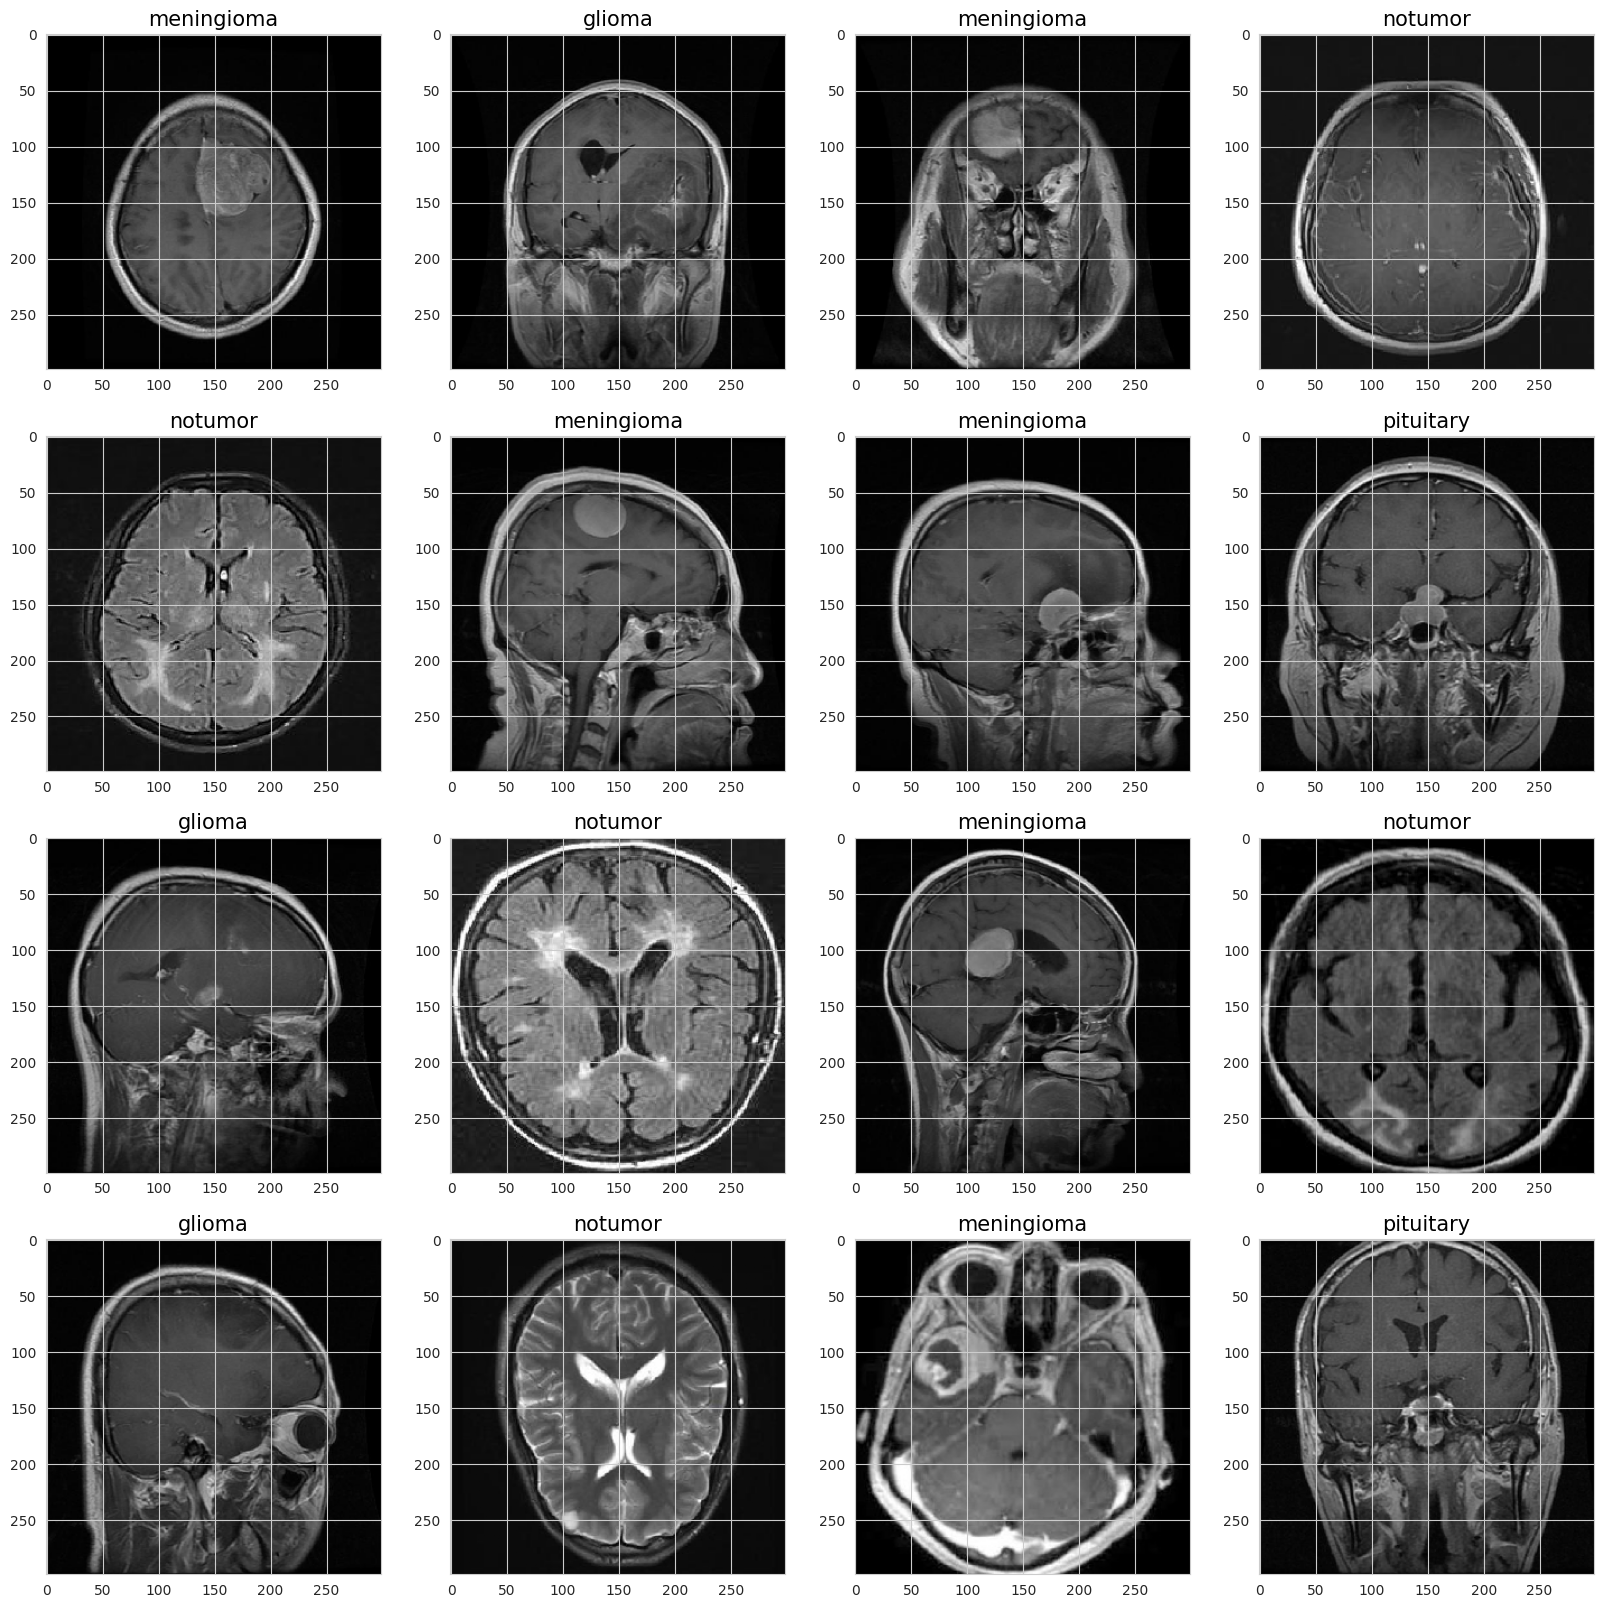

In [12]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))

for i, (image, label) in enumerate(zip(images, labels)):
  plt.subplot(4, 4, i+1)
  plt.imshow(image)
  class_name = classes[np.argmax(label)]
  plt.title(class_name, color='k', fontsize=15)

plt.show()

## Construimos el modelo de Deep Learning

In [13]:
img_shape=(299, 299, 3)
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',
                                            input_shape=img_shape, pooling='max')

model = Sequential([
  base_model,
  Flatten(),
  Dropout(rate=0.3),
  Dense(128, activation='relu'),
  Dropout(rate=0.25),
  Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       Precision(),
                       Recall()])

model.summary()

2025-03-31 11:46:43.388657: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


# Entrenamiento

In [ ]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle=False)

hist.history.keys()

Epoch 1/10


2025-03-31 11:47:07.336501: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.
2025-03-31 11:47:07.546691: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.
2025-03-31 11:47:07.651738: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.
2025-03-31 11:47:07.721864: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.
2025-03-31 11:47:08.996498: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 354041856 exceeds 10% of free system memory.


## Visualizamos el rendimiento del modelo 

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f"Mejor época = {str(index_loss + 1)}"
acc_label = f"Mejor época = {str(index_acc + 1)}"
per_label = f"Mejor época = {str(index_precision + 1)}"
recall_label = f"Mejor época = {str(index_recall + 1)}"

plt.figure(figsize=(20, 12))
plt.style.use('fivethrityeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()